<a href="https://colab.research.google.com/github/princeyyadav/cellular_aging/blob/master/HDS_calculation_and_age_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# install libraries

In [2]:
!pip install velocyto matplotlib seaborn matplotlib-venn scikit-learn 

     |████████████████████████████████| 204kB 2.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 10.0MB 18.9MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for velocyto: filename=velocyto-0.17.17-cp36-cp36m-linux_x86_64.whl size=363577 sha256=9d4173547b5e5cb11532d7f9c448751892e74e2315ac4d98ec7c3181cc22633a
  Stored in directory: /root/.cache/pip/wheels/e0/10/47/5a2aa6a7179b17b50a19cdba1df71798ade77e7d9ce98c5300
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=8f42b04a03db0056634f6251a3fb41c1a83484dc714915311b23089c7c14ae75
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=8940258707b1a1f785f8a4a7f447c52acfcd59db6f42b460fc63b6c486507b95
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f953

# import library

In [3]:
import time
import scipy
import pickle
import numpy as np
import pandas as pd
import velocyto as vcy

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as ven
from matplotlib.gridspec import GridSpec

import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, cohen_kappa_score, confusion_matrix, recall_score, classification_report, precision_score
from scipy.stats import spearmanr, zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# path variables

In [5]:
# path variables
path = {}
root = "/content/drive/My Drive/cellular-aging-code/"
path["loom"] = root + "data/pancreas.hdf5"
path["metadata"] = root + "data/metadata.csv"
path["sigi"] = root+"data/significant_restoration_genes_across_all_cells.csv"
path["sigd"] = root+"data/significant_hb_genes_across_all_cells.csv"
path['r2'] = root+"data/r2_all_cells.csv"
path["velocity_age_0p025"] = root+"data/Velocity_0p025_age_specific_gamma.csv"

# plots save location
path['save'] = root+"plots/"

# load loom file

In [6]:
%%time
# load data

vlm = vcy.load_velocyto_hdf5(path["loom"])
vlm.ca["CellID"] = np.asarray(vlm.ca["CellID"])

CPU times: user 9.07 s, sys: 1.32 s, total: 10.4 s
Wall time: 11.3 s


# gamma & velocity estimation

(16569, 2481)
n_comps 12
k 62
CPU times: user 1min 51s, sys: 4.71 s, total: 1min 56s
Wall time: 1min 23s


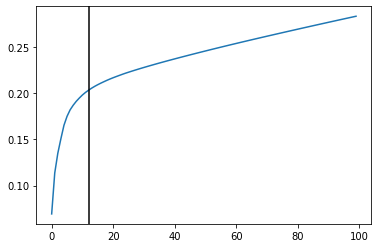

In [ ]:
%%time
# # load loom file
# vlm = vcy.load_velocyto_hdf5(path["loom"])
# vlm.ca['CellID'] = np.asarray(vlm.ca['CellID'])
# print(vlm.S.shape)

# gene filtering 
vlm.score_detection_levels(min_cells_express=20, min_expr_counts=50)
vlm.filter_genes(by_detection_levels=True)
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.filter_genes(by_detection_levels=True)
print(vlm.S.shape)

# size normalization
vlm._normalize_S(relative_size=vlm.initial_cell_size, target_size=np.median(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size, target_size=np.median(vlm.initial_Ucell_size))

# PCA
vlm.perform_PCA()
pcn = vlm.S.shape[0]
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print("n_comps", n_comps)

# KNN smoothing
k = int(vlm.S.shape[1]*0.025)
print("k",k)
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

# fit gamma
vlm.fit_gammas()

# estimate velocity
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.,)


# Helpers

In [ ]:

def r2_feature_wise(vlm, feature="age"):
  """ returns a numpy array of R-squared value for each gene feature wise"""
  uni = np.sort(np.unique(vlm.ca[feature]))
  dim2 = uni.shape[0]
  r2f = np.zeros(shape=(vlm.S.shape[0],dim2))
  for i in range(dim2):
      x = uni[i]
      samples = (vlm.ca[feature]==x)
      for j in range(vlm.S.shape[0]):
          r2f[j,i] = r2_score(y_true=vlm.Ux_sz[j,samples], y_pred=vlm.Upred[j,samples])
  return r2f



# R-squared estimation

In [ ]:
# compute r-squared decade wise
decades = np.unique(vlm.ca['decade'])
r2 = r2_feature_wise(vlm, feature='decade')

# save r2 matrix in csv format
r2df = pd.DataFrame(r2, index=vlm.ra['Gene'], columns=decades)
# r2df.to_csv(root+"data/r2_all_cells.csv")
print(r2df.shape)
r2df.head()

(16569, 5)


,1,3,4,5,6
WASH7P,-0.096609,-3.153871,-3.603690,-5.557183,-2.789676
RP11-34P13.7,-0.193170,-0.247431,-0.220562,-0.661081,-0.860929
AL627309.1,-0.112608,-0.194672,-0.688137,-0.097712,-0.474185
RP11-34P13.13,-0.966125,-0.320908,-1.388539,-1.956817,-0.711319
AP006222.2,-0.123642,-0.038185,-1.139524,-0.900147,-1.242045


# capture monotonicity

In [ ]:
# load r-squared matrix
r2 = pd.read_csv(path['r2'], index_col=0)
print(r2.shape)
print(r2.head())

(16569, 5)
                      1         3         4         5         6
WASH7P        -0.096609 -3.153871 -3.603690 -5.557183 -2.789676
RP11-34P13.7  -0.193170 -0.247431 -0.220562 -0.661081 -0.860929
AL627309.1    -0.112608 -0.194672 -0.688137 -0.097712 -0.474185
RP11-34P13.13 -0.966125 -0.320908 -1.388539 -1.956817 -0.711319
AP006222.2    -0.123642 -0.038185 -1.139524 -0.900147 -1.242045


In [ ]:
%%time
# compute spearman rank correlation b/w r2 vector of each gene and the time vector
cor = np.zeros(r2.shape[0], dtype=float)
pval = np.zeros(r2.shape[0], dtype=float)

# find spearman correlation and associated 2 tailed p-value
time = [1,2,3,4,5]
for i in range(r2.shape[0]):
  cor[i,], pval[i,] = spearmanr(a=r2.iloc[i,:].values, b=time) # correlation, pval

print("significant genes", (pval<=0.025).sum())
print("restoration genes", ((pval<=0.025) & (cor>0.9)).sum())
print("homeostasis breakdown genes", ((pval<0.025) & (cor<-0.9)).sum())

significant genes 211
restoration genes 40
homeostasis breakdown genes 171
CPU times: user 13.5 s, sys: 12 ms, total: 13.5 s
Wall time: 13.5 s


In [ ]:
# monotonically decreasing genes/ homeostasis breakdown genes
temp = ((pval<0.025) & (cor<=-0.9))
genes = r2.index[temp]

sig = r2.loc[genes,:]
sig['spcor'] = cor[temp]
sig['pval'] = pval[temp]
print(sig.shape)
print(sig.head())
# save breakdown genes
# sig.to_csv(root+"data/significant_hb_genes_across_all_cells.csv")

# monotonically increasing genes/ restoration genes
temp = ((pval<0.025) & (cor>=0.9))
genes = r2.index[temp]

sig = r2.loc[genes,:]
sig['spcor'] = cor[temp]
sig['pval'] = pval[temp]
print(sig.shape)
print(sig.head())
# save restoration genes
# sig.to_csv(root+"data/significant_restoration_genes_across_all_cells.csv")

(171, 7)
                      1         3         4  ...          6  spcor          pval
RP11-288I21.1  0.171988 -0.226690 -0.384908  ...  -2.533655   -1.0  1.404265e-24
ALDH4A1        0.037180 -0.123532 -0.501665  ... -24.485357   -1.0  1.404265e-24
RP11-12C17.2   0.887795  0.787421  0.754243  ...  -0.115750   -1.0  1.404265e-24
AP4B1          0.221113  0.136238  0.106252  ...  -1.410580   -1.0  1.404265e-24
UBQLN4        -0.009241 -0.086891 -0.133781  ...  -3.201928   -1.0  1.404265e-24

[5 rows x 7 columns]
(40, 7)
                    1         3         4  ...         6  spcor          pval
G0S2        -0.010112  0.366185  0.440473  ...  0.683474    1.0  1.404265e-24
TIMM23B     -1.400736 -0.812315 -0.705927  ... -0.299262    1.0  1.404265e-24
RP11-22P4.1 -0.895384 -0.480110 -0.414506  ... -0.065096    1.0  1.404265e-24
MDM1        -1.837173 -1.164380 -0.093415  ...  0.098547    1.0  1.404265e-24
SYNE2        0.450121  0.458937  0.484715  ...  0.667998    1.0  1.404265e-24

[5 row

# Figures

##A) #Genes with r-squared<0

[ 9936 11155 10964 11445 12054]


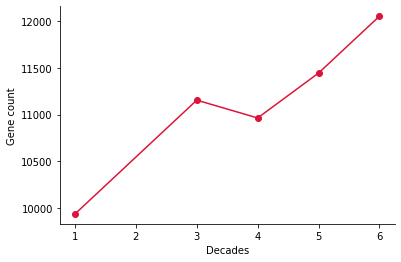

In [ ]:
decades = [int(i) for i in r2.columns]
count = (r2<0).sum(0).values
print(count)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(decades, count, "o-", c='crimson')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Decades')
plt.ylabel('Gene count')
plt.savefig(path['save']+'fig_B.pdf', bbox_inches='tight', dpi=600)

##B) Count of breakdown and restoration genes

In [10]:
sigi = pd.read_csv(path["sigi"], index_col=0)
sigd = pd.read_csv(path["sigd"], index_col=0)
print(sigi.shape, sigd.shape)

(40, 7) (171, 7)


In [ ]:
df = pd.DataFrame(columns = ['Count', 'Genes'])
newrow = {
    'Count': sigd.shape[0],
    'Genes': 'Breakdown'
}

df = df.append(newrow, ignore_index=True)
newrow = {
    'Count': sigi.shape[0],
    'Genes': 'Restoration'
}
df = df.append(newrow, ignore_index=True)
df

,Count,Genes
0,171,Breakdown
1,40,Restoration


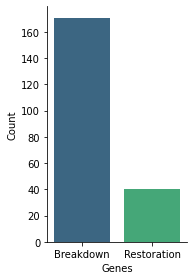

In [ ]:
sns.catplot(x='Genes', y='Count', data=df, kind='bar', palette='viridis', height=4, aspect=0.7)
plt.savefig(path['save']+'fig_C.pdf', bbox_inches='tight', dpi=600)

## C) ZNRF1 homeostasis breakdown

In [ ]:
def plot_genes_r2_phase_portrait_supp_hb(vlm, df, genes, figname):

  color = ["crimson", "deeppink", "dodgerblue", "green", "darkorange"]
  decades = np.unique(vlm.ca["decade"])
  ncol = 6
  nrow = genes.shape[0]
  w = 4*ncol
  h = 4*nrow
  fig = plt.figure(figsize=(w,h))
  gs = GridSpec(nrows=nrow, ncols=ncol, hspace=0.3, wspace=0.3)
  i=0

  for g in genes:
    try:
      idx = np.where(vlm.ra["Gene"]==g)[0][0]
    except:
      pass

    k=0
    c=0
    # plot phase portrait

    for d in decades:

      samples = vlm.ca["decade"]==d
      ax = fig.add_subplot(gs[i,k])
      plt.scatter(vlm.Sx_sz[idx,samples], vlm.Ux_sz[idx,samples], s=50, c=color[c], alpha=0.5)
      xnew = np.linspace(0, (vlm.Sx_sz[idx,samples]).max()+0.01)
      plt.plot(xnew, vlm.gammas[idx]*(xnew)+vlm.q[idx], color="k", linewidth=1)
      # plt.ylabel("u", fontsize=11)
      # plt.xlabel("s", fontsize=11)
      ax.spines['right'].set_visible(False)
      ax.spines['top'].set_visible(False)
      plt.title(f'Decade {d}', loc='center')
      k+=1
      c+=1

    # plot r-squared
    ix = np.where(df.index==g)[0][0]
    ax = fig.add_subplot(gs[i,k])
    temp = df.iloc[ix,:-2].values<0
    h=0.6
    plt.barh(df.columns[:-2][~temp], df.iloc[ix,:-2][~temp], height=h, color='dodgerblue',  )
    plt.barh(df.columns[:-2][temp], df.iloc[ix,:-2][temp], height=h, color='#d60000',  )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.invert_yaxis()
    # plt.xlim(np.min(sigd.iloc[idx,:-2])-0.5, 1.5)
    # plt.xticks(ticks=[-5,-3,0,1], label=[-5,-3,0,1])
    plt.ylabel("Decade")
    plt.xlabel("R2")
    plt.title(g, loc='center')

    k+=1
    i+=1
  if figname:
    plt.savefig(path['save']+f"{g}_hb_phase_portrait.pdf", bbox_inches='tight', dpi=600)
  else:
    plt.savefig(path['save']+"hb_phase_portrait.pdf", bbox_inches='tight', dpi=600)


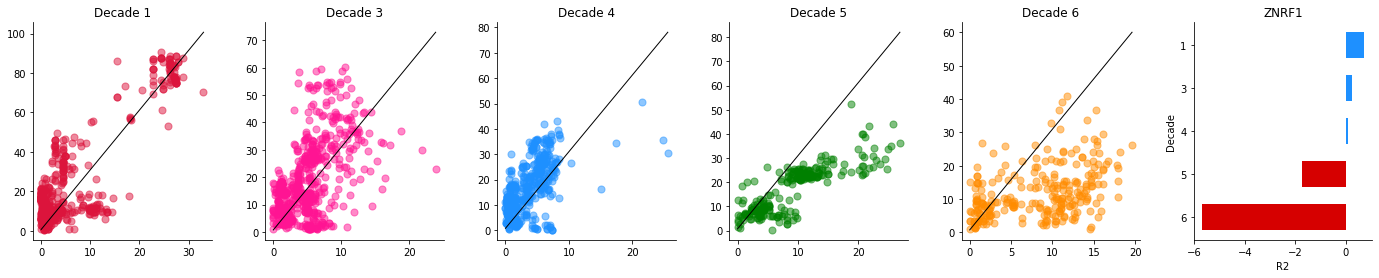

In [ ]:
genes = np.asarray(['ZNRF1'])
plot_genes_r2_phase_portrait_supp_hb(vlm, sigd, genes, figname=True)

## Supplementary figure 1: Phase portrait of breakdown genes

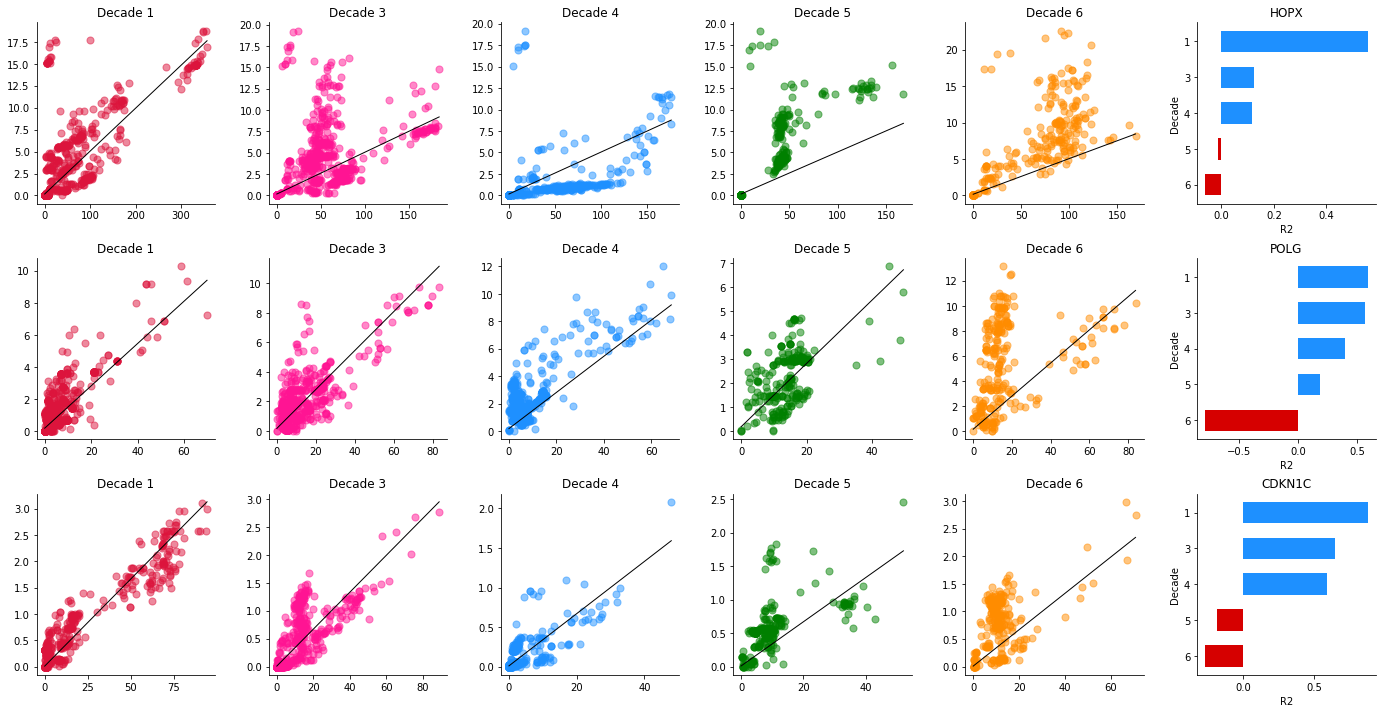

In [ ]:
good_genes = np.asarray([
# 'PDHX',
'HOPX',
'POLG',
'CDKN1C',
])
plot_genes_r2_phase_portrait_supp_hb(vlm, sigd, good_genes, figname=False)

## Supplementary figure 2: Phase portrait of restoration genes

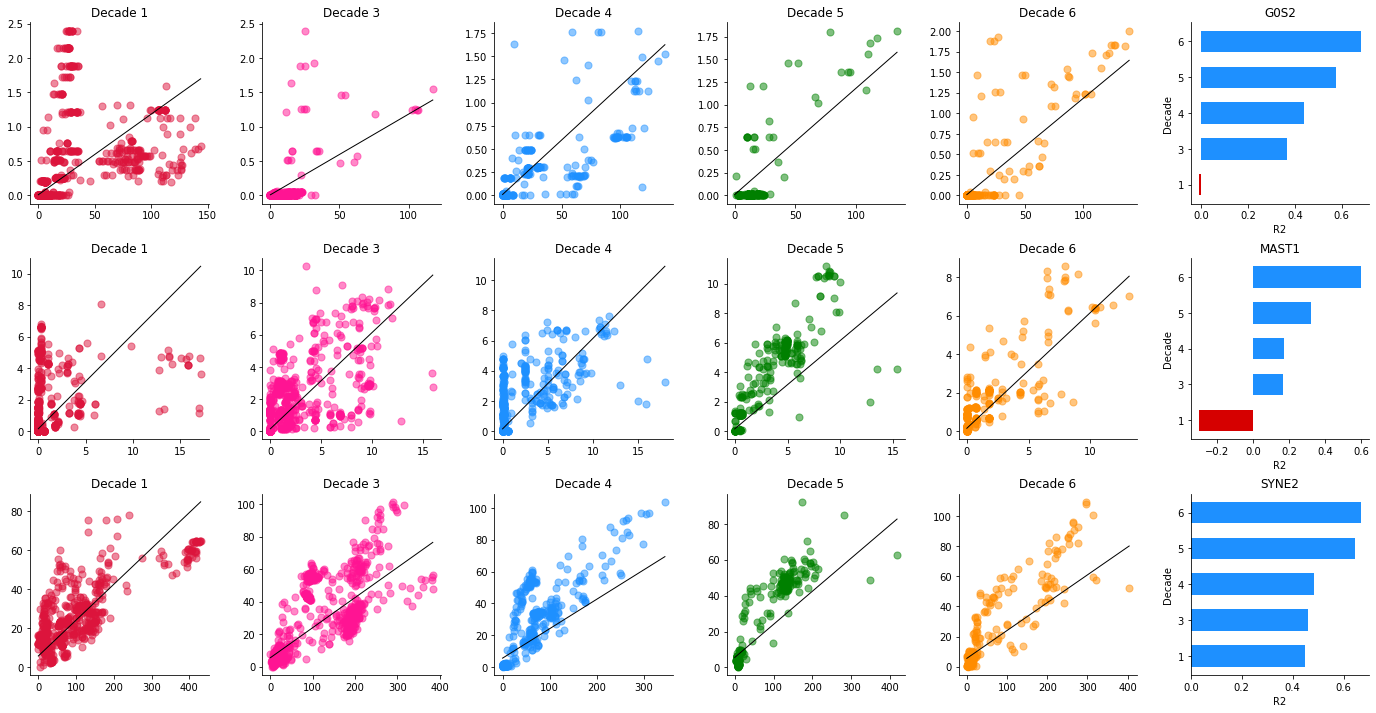

In [ ]:
def plot_genes_r2_phase_portrait_res(vlm, df, genes, figname):

  color = ["crimson", "deeppink", "dodgerblue", "green", "darkorange"]
  decades = np.unique(vlm.ca["decade"])
  ncol = 6
  nrow = genes.shape[0]
  w = 4*ncol
  h = 4*nrow
  fig = plt.figure(figsize=(w,h))
  gs = GridSpec(nrows=nrow, ncols=ncol, hspace=0.3, wspace=0.3)
  i=0

  for g in genes:
    try:
      idx = np.where(vlm.ra["Gene"]==g)[0][0]
    except:
      pass

    k=0
    c=0
    # plot phase portrait

    for d in decades:

      samples = vlm.ca["decade"]==d
      ax = fig.add_subplot(gs[i,k])
      plt.scatter(vlm.Sx_sz[idx,samples], vlm.Ux_sz[idx,samples], s=50, c=color[c], alpha=0.5)
      xnew = np.linspace(0, (vlm.Sx_sz[idx,samples]).max()+0.01)
      plt.plot(xnew, vlm.gammas[idx]*(xnew)+vlm.q[idx], color="k", linewidth=1)
      # plt.ylabel("u", fontsize=11)
      # plt.xlabel("s", fontsize=11)
      ax.spines['right'].set_visible(False)
      ax.spines['top'].set_visible(False)
      plt.title(f'Decade {d}', loc='center')
      k+=1
      c+=1

    # plot r-squared
    ix = np.where(df.index==g)[0][0]
    ax = fig.add_subplot(gs[i,k])
    temp = df.iloc[ix,:-2].values<0
    h=0.6
    plt.barh(df.columns[:-2][temp], df.iloc[ix,:-2][temp], height=h, color='#d60000',  )
    plt.barh(df.columns[:-2][~temp], df.iloc[ix,:-2][~temp], height=h, color='dodgerblue',  )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel("Decade")
    plt.xlabel("R2")
    plt.title(g, loc='center')

    k+=1
    i+=1
  
  if figname:
    plt.savefig(path['save']+f"{g}_res_phase_portrait.pdf", bbox_inches='tight', dpi=600)
  else:
    plt.savefig(path['save']+"res_phase_portraits.pdf", bbox_inches='tight', dpi=600)

 
good_genes = np.asarray(['G0S2','MAST1','SYNE2'])
plot_genes_r2_phase_portrait_res(vlm, sigi, good_genes, figname=False)

# Cellular Age Prediction using homeostasis divergence as feature

## Age wise estimation of velocity

In [ ]:
%%time
feature = "age"
unique_features = np.unique(vlm.ca[feature])
total = vlm.S.shape[1]

CPU times: user 977 µs, sys: 37 µs, total: 1.01 ms
Wall time: 1.26 ms


(16569, 2481)
No. of samples of age 1: 220
n_comps 199
k 5
(16569, 2481)
No. of samples of age 5: 315
n_comps 216
k 7
(16569, 2481)
No. of samples of age 6: 176
n_comps 172
k 4
(16569, 2481)
No. of samples of age 21: 505
n_comps 133
k 12
(16569, 2481)
No. of samples of age 22: 269
n_comps 256
k 6
(16569, 2481)
No. of samples of age 38: 469
n_comps 145
k 11
(16569, 2481)
No. of samples of age 44: 267
n_comps 252
k 6
(16569, 2481)
No. of samples of age 54: 260
n_comps 245
k 6
CPU times: user 3min 22s, sys: 4.81 s, total: 3min 26s
Wall time: 3min 17s


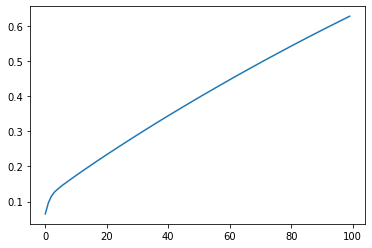

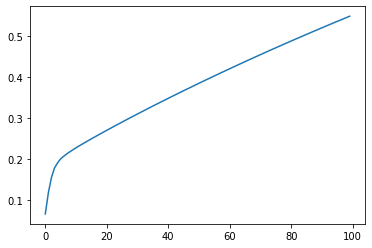

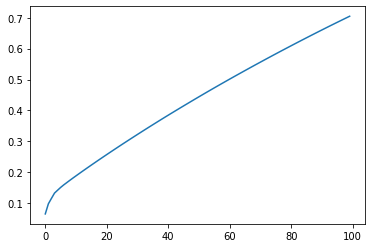

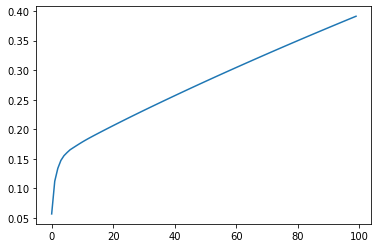

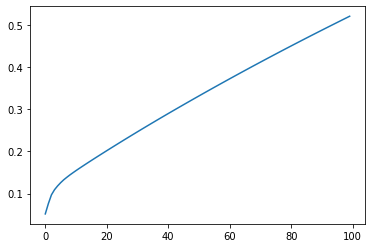

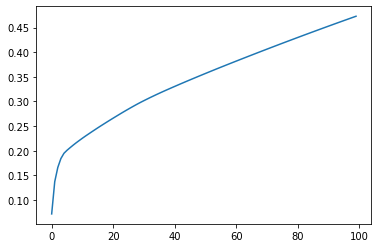

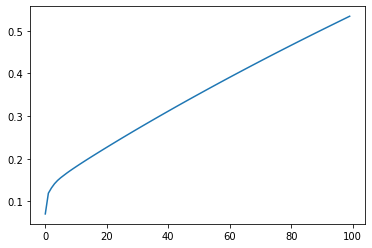

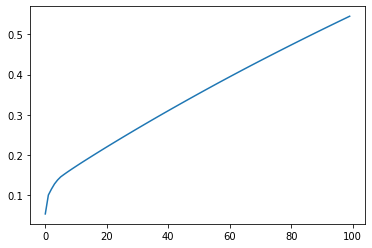

In [ ]:
%%time
q = []
cod = [] # coefficient of determination
gamma = []
for i in range(unique_features.shape[0]):
  uf = unique_features[i]
  # load loom file
  vi = vcy.load_velocyto_hdf5(path["loom"])
  vi.ca['CellID'] = np.asarray(vi.ca['CellID'])

  # gene filtering 
  vi.score_detection_levels(min_cells_express=20, min_expr_counts=50)
  vi.filter_genes(by_detection_levels=True)
  vi.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
  vi.filter_genes(by_detection_levels=True)
  print(vi.S.shape)

  # cell filtering 
  samples = vi.ca[feature]==uf
  print("No. of samples of {} {}: {}".format(feature, uf, samples.sum()))  
  vi.filter_cells(samples)

  # size normalization
  vi._normalize_S(relative_size=vi.initial_cell_size, target_size=np.median(vi.initial_cell_size))
  vi._normalize_U(relative_size=vi.initial_Ucell_size, target_size=np.median(vi.initial_Ucell_size))

  # PCA
  vi.perform_PCA()
  pcn = vi.S.shape[0]
  plt.figure()
  plt.plot(np.cumsum(vi.pca.explained_variance_ratio_)[:100])
  n_comps = np.where(np.diff(np.diff(np.cumsum(vi.pca.explained_variance_ratio_))>0.002))[0][0]
  print("n_comps", n_comps)

  # KNN smoothing
  k = int(samples.sum()*0.025)
  print("k",k)
  vi.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

  # fit gamma
  vi.fit_gammas()
  # vi = fit_gammas(vi, steady_state_bool=samples)

  # estimate velocity
  vi.predict_U()
  vi.calculate_velocity()
  vi.calculate_shift(assumption="constant_velocity")
  vi.extrapolate_cell_at_t(delta_t=1.,)

  # save gammas, offset, coefficient of determination
  gamma.append(vi.gammas)
  q.append(vi.q)
  cod.append(vi.R2)

  # reassign attributes' values for current subset of samples
  vlm.Upred[:,samples] = vi.Upred
  vlm.delta_S[:,samples] = vi.delta_S
  vlm.Sx_sz_t[:,samples] = vi.Sx_sz_t
  vlm.velocity[:,samples] = vi.velocity

In [ ]:
%%time
# save velocity, Sx, Ux, Sx_sz, Ux_sz, Upred
savedf = [vlm.Sx, vlm.Ux, vlm.Sx_sz, vlm.Ux_sz, vlm.Upred, vlm.velocity]
filenames = [
         "Sx_0p025_age_specific_gamma.csv",
         "Ux_0p025_age_specific_gamma.csv",
         "Sx_sz_0p025_age_specific_gamma.csv",
         "Ux_sz_0p025_age_specific_gamma.csv",
         "Upred_0p025_age_specific_gamma.csv",
         "Velocity_0p025_age_specific_gamma.csv",
         ]
for fname,mat in zip(filenames,savedf):
  fpath = currentdir+fname
  print(fpath, mat.shape)
  df = pd.DataFrame(mat, index=vlm.ra['Gene'], columns=vlm.ca['geo_accession'])
  df = df.transpose()
  print("after transpose", df.shape)
  df.to_csv(fpath)

/content/drive/My Drive/Thesis/newPipe/v1_decade_specific_gamma/k_0_pt_025/Sx_0p025_age_specific_decade.csv (16569, 2481)
after transpose (2481, 16569)
/content/drive/My Drive/Thesis/newPipe/v1_decade_specific_gamma/k_0_pt_025/Ux_0p025_age_specific_decade.csv (16569, 2481)
after transpose (2481, 16569)
/content/drive/My Drive/Thesis/newPipe/v1_decade_specific_gamma/k_0_pt_025/Sx_sz_0p025_age_specific_decade.csv (16569, 2481)
after transpose (2481, 16569)
/content/drive/My Drive/Thesis/newPipe/v1_decade_specific_gamma/k_0_pt_025/Ux_sz_0p025_age_specific_decade.csv (16569, 2481)
after transpose (2481, 16569)
/content/drive/My Drive/Thesis/newPipe/v1_decade_specific_gamma/k_0_pt_025/Upred_0p025_age_specific_decade.csv (16569, 2481)
after transpose (2481, 16569)
/content/drive/My Drive/Thesis/newPipe/v1_decade_specific_gamma/k_0_pt_025/Velocity_0p025_age_specific_decade.csv (16569, 2481)
after transpose (2481, 16569)
CPU times: user 7min 42s, sys: 4.8 s, total: 7min 47s
Wall time: 8min 9s


## Read age wise velocity matrix

In [8]:
# read velocity  matrix
# Sx_sz = pd.read_csv(path["Sx_sz"], index_col=0)
vel = pd.read_csv(path["velocity_age_0p025"], index_col=0)
print(vel.shape)
# transpose velocity matrix
# vel = vel.transpose()
print(vel.shape)
vel.head()

(2481, 16569)
(2481, 16569)


,WASH7P,RP11-34P13.7,AL627309.1,RP11-34P13.13,AP006222.2,RP11-206L10.1,RP11-206L10.3,RP11-206L10.5,RP11-206L10.2,RP11-206L10.8,RP11-206L10.10,NOC2L,HES4,C1orf159,TNFRSF18,SDF4,UBE2J2,ACAP3,CPSF3L,MXRA8,AURKAIP1,CCNL2,MRPL20,ANKRD65,SSU72,CDK11B,SLC35E2B,CDK11A,SLC35E2,NADK,GNB1,TMEM52,RP11-181G12.2,C1orf86,MORN1,PEX10,PANK4,RP3-395M20.8,MMEL1,LINC00982,...,ZNF185,ZNF275,BGN,SLC6A8,ABCD1,PLXNB3,SSR4,TMEM187,EMD,RPL10,TAZ,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,DKC1,FUNDC2,BRCC3,VBP1,TMLHE-AS1,VAMP7,SRY,ZFY-AS1,GYG2P1,UTY,TTTY14,KDM5D,RPS4Y1,ZFY,TBL1Y,PRKY,TTTY15,USP9Y,DDX3Y,PSMA6P1,KALP,NLGN4Y,TXLNG2P,EIF1AY
GSM2171880,-0.047783,0.178060,-0.004516,-0.277579,1.918035,-0.000455,-0.164491,-0.472687,-0.185569,-5.204466,-1.260092,-0.027091,-0.001422,-0.083564,0.0,-0.390152,0.476239,-0.170530,-0.034897,-0.000406,-0.033111,-0.175883,-0.489910,-0.103362,-3.805006,-2.692584,-2.142719,-0.006807,0.015258,-1.255851,-9.705552,-0.000190,-0.000877,0.041519,-0.619605,-0.622102,-0.476256,-0.000175,0.412348,-0.001187,...,0.067909,-5.881389,-0.000207,-1.934134e-01,-0.021041,-0.026487,-0.530175,-0.243387,-1.460512,3.205460,-0.366624,-1.653260,-0.371515,-0.658711,-0.149456,-0.130509,-7.820771,-23.006439,-14.766210,-31.136404,-8.838527,-30.527930,-0.000151,-10.350191,-0.707165,-21.081519,-1255.940377,-30.796550,-4.389544,-15.832580,92.019819,12.441764,-3.976444,-6.265133,-4.965536,-0.068942,0.485880,51.350130,11.006023,-16.459180
GSM2171881,-0.047783,-0.029896,-0.003305,1.071095,-0.995899,-0.000455,-0.030966,-0.288558,-0.102569,-0.502778,0.290672,-0.028998,-0.001422,-0.083564,0.0,0.132117,-2.181161,-0.167198,-0.362557,-0.000406,-0.038913,0.425381,-1.172391,-0.216953,-0.472337,-2.315109,-2.892387,0.022149,-0.033780,-1.218302,16.118164,-0.000190,-0.000877,-0.025491,-0.619605,-0.665840,-0.000029,-0.000175,1.477890,-0.001187,...,0.072574,-1.862665,-0.000207,-8.597860e-17,-0.021041,-0.003734,0.092061,-0.319847,-0.964297,1.541266,-0.465003,-1.160088,-0.945185,-0.658711,-0.116551,-0.112034,-8.046720,-8.096193,33.872997,-24.279377,16.959409,-6.250570,-0.000151,-12.671250,-0.707165,-3.414476,-1263.204925,-5.903438,-12.921945,-14.979635,50.702717,-0.252604,15.091466,21.552238,-7.884355,-0.088581,-0.077070,90.321641,-5.344319,-12.606055
GSM2171882,-0.047783,0.654504,-0.003305,-1.395787,-0.138898,-0.000455,-0.009877,-0.063698,-0.088482,1.196893,-0.223968,-0.024095,-0.001422,-0.037833,0.0,1.430859,-2.641579,-0.166916,-0.351837,-0.000406,-0.024939,-0.218997,-0.192595,-0.022342,-2.734394,-2.458436,-0.713655,-0.211876,-0.033780,-1.566619,24.763479,-0.202506,-0.000877,-0.025491,0.021276,-0.306155,-0.294602,-0.000175,-0.020086,-0.001187,...,-0.004394,-5.649950,-0.000207,2.089499e-01,-0.021041,-0.003734,0.360201,-0.252810,-0.997396,0.878979,1.553749,-0.421924,-0.369979,-0.658711,-0.138643,-0.039494,-5.746202,-14.538222,-25.000651,-10.684657,10.395667,19.663160,-0.000151,-2.748680,-0.707165,13.166330,2052.526402,-13.740678,-31.410244,-14.094628,16.141452,17.473033,-3.729189,-8.612942,-11.096288,-0.135126,-0.115554,-7.904634,-14.708407,33.186943
GSM2171883,-0.047783,0.178060,-0.003305,0.970904,1.007548,-0.000455,-0.149007,0.324000,0.247504,-0.502778,0.290672,-0.024290,-0.001422,-0.037833,0.0,0.384849,0.861934,-0.182512,-0.122895,-0.000406,-0.040205,-1.026812,-0.279808,-0.229764,-4.208468,-1.091996,-0.226100,-0.292254,0.031497,-1.530772,7.562763,-0.000190,-0.304593,-0.101090,1.369609,-0.230380,-0.577106,-0.000175,-0.020086,-0.001187,...,0.067909,1.060254,-0.000207,-8.597860e-17,-0.021041,-0.003734,-0.947486,-0.236913,-0.532592,0.542439,-0.462732,-1.699139,-0.697294,-0.514960,-0.101883,-0.203049,-6.737436,-11.754441,51.031668,-1.142685,14.234714,-3.247292,-0.000151,-10.745018,-0.707165,2.572991,-1414.151431,16.843988,-21.592161,-21.222116,47.897052,-0.252604,23.523268,-33.088496,-9.408137,-0.142553,0.071789,27.809557,-9.528218,-15.227815
GSM2171884,-0.047783,-0.029896,-0.003305,-0.033726,3.494143,-0.000455,0.163556,0.197561,-0.127408,-4.747410,-3.184354,-0.029650,-0.001422,-0.08

In [11]:
# get all 211 significant monotonic genes
genes = np.concatenate([sigi.index.values, sigd.index.values])
print(genes.shape)
print(*genes)

(211,)
G0S2 TIMM23B RP11-22P4.1 MDM1 SYNE2 LACTB ZNF597 STX4 ATPAF2 COPRS TIMP2 TMEM102 ZNF846 CTB-179K24.3 AC022154.7 MAST1 ZNF492 OVOL2 ZNF133 TUBB1 YWHAH UGT2B17 PRMT10 RTN4IP1 RP11-428J1.5 PAQR8 RP11-797H7.5 TMEM243 TMEM168 DERL1 ARHGEF10 PSIP1 CBWD5 PTAR1 TRPM3 GLIPR2 C9orf89 HABP4 GPC4 RP11-622K12.1 RP11-288I21.1 ALDH4A1 RP11-12C17.2 AP4B1 UBQLN4 ILDR2 ACBD3 IQCC ST6GALNAC5 PRPF38B RP6-206I17.2 CKS1B EFNA1 RUSC1 DAP3P1 DYRK3 DCLRE1C CPEB3 FUOM MCU DOCK1 CDKN1C HSPA8 RP11-1H15.2 PDHX RP11-286N22.8 NDUFV1 RPAP3 RARG ATP5G2 CTDSP2 SVOP CAMKK2 CDK2AP1 RP11-96H19.1 GPC6-AS2 DNAJC3-AS1 WASF3 AKAP11 ARHGEF7 VCPKMT GPR135 FOXN3 CDKN3 VASH1 SLC12A6 HDGFRP3 POLG FAM92A1P1 GALK2 TERF2 RP11-498D10.5 ADAMTS18 GCSH GNPTG ZNRF1 MON1B TCF25 NUP88 LINC00671 RP11-180P8.1 GRB2 DNAH17 RP11-1260E13.2 RP11-314A20.2 GRB7 WNK4 CEP76 RNF126 PLIN3 CTD-3193O13.9 CD320 FBXL12 KIAA1683 ZNF100 SERTAD1 AC012314.8 TNFAIP8L1 CTC-325H20.4 CCDC159 AP1M1 CAPNS1 SAMD4B AC007193.6 CALM3 FCGRT ZNF137P ZNF543 ADAM17 CA

## Labeling samples based on age group  
- Age 1, 5, 6 - Children (0)  
- Age 21, 22 - Young adults (1)  
- Age 38, 44, 54 - Middle-aged (2)  

In [15]:
decade_labels = vlm.ca['decade']
age_labels = vlm.ca['age']
labels = vlm.ca['age']
age = np.unique(age_labels)
cat_labels = np.zeros(vlm.ca['decade'].shape, dtype=int)
print(cat_labels.shape, age_labels.shape)
for i,a in enumerate(age_labels):
  if a in [1,5,6]:
    cat_labels[i,] = 0 # Juvenile
  elif a in [21,22]:
    cat_labels[i,] = 1 # young adults
  elif a in [38,44,54]:
    cat_labels[i,] = 2 # middle aged
print(np.unique(cat_labels))
print(*age)
print(*cat_labels)

(2481,) (2481,)
[0 1 2]
1 5 6 21 22 38 44 54
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

## Trimerization  
Replace:  
- negative velocities with 0
- 0 velocities with 1
- positive velocities with 3  
This technique improved the accuracy manifolds

In [13]:
nonp2 = np.where(vel>0, 3, 0)
nonp2 = np.where(vel<0, 0, nonp2)
nonp2 = np.where(vel==0, 1, nonp2)

print((nonp2==2).sum().sum(), (nonp2==1).sum().sum(), (nonp2==0).sum().sum())
print((vel>0).sum().sum(), (vel==0).sum().sum(), (vel<0).sum().sum())
print(nonp2.shape)
nonp2 = pd.DataFrame(nonp2, index=vel.index, columns=vel.columns)
print(nonp2.shape)
nonp2.head()

0 2331021 28416233
10360435 2331021 28416233
(2481, 16569)
(2481, 16569)


,WASH7P,RP11-34P13.7,AL627309.1,RP11-34P13.13,AP006222.2,RP11-206L10.1,RP11-206L10.3,RP11-206L10.5,RP11-206L10.2,RP11-206L10.8,RP11-206L10.10,NOC2L,HES4,C1orf159,TNFRSF18,SDF4,UBE2J2,ACAP3,CPSF3L,MXRA8,AURKAIP1,CCNL2,MRPL20,ANKRD65,SSU72,CDK11B,SLC35E2B,CDK11A,SLC35E2,NADK,GNB1,TMEM52,RP11-181G12.2,C1orf86,MORN1,PEX10,PANK4,RP3-395M20.8,MMEL1,LINC00982,...,ZNF185,ZNF275,BGN,SLC6A8,ABCD1,PLXNB3,SSR4,TMEM187,EMD,RPL10,TAZ,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,DKC1,FUNDC2,BRCC3,VBP1,TMLHE-AS1,VAMP7,SRY,ZFY-AS1,GYG2P1,UTY,TTTY14,KDM5D,RPS4Y1,ZFY,TBL1Y,PRKY,TTTY15,USP9Y,DDX3Y,PSMA6P1,KALP,NLGN4Y,TXLNG2P,EIF1AY
GSM2171880,0,3,0,0,3,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,0,...,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,3,3,3,0
GSM2171881,0,0,0,3,0,0,0,0,0,0,3,0,0,0,1,3,0,0,0,0,0,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,0,...,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,3,0,3,3,0,0,0,3,0,0
GSM2171882,0,3,0,0,0,0,0,0,0,3,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,...,0,0,0,3,0,0,3,0,0,3,3,0,0,0,0,0,0,0,0,0,3,3,0,0,0,3,3,0,0,0,3,3,0,0,0,0,0,0,0,3
GSM2171883,0,3,0,3,3,0,0,3,3,0,3,0,0,0,1,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,3,0,0,0,0,0,...,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,3,0,3,0,0,3,0,3,0,0,0,3,3,0,0
GSM2171884,0,0,0,0,3,0,3,3,0,0,0,0,0,0,1,3,0,0,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,3,0,...,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,3,3,3,0


## Prediction using Leave One Donor Out  
- Iterate on the unique aged individuals  
- In each iteration, test set consists of samples from one donor and model is trained on rest of the samples
- Set of samples' age: {1 5 6 21 22 38 44 54}  
- In first iteration, test set contains samples from donor of age 1 and training set contained rest of the samples    
- In second iteration, test set contains samples from donor of age 5  
- and so on...

Unique ages [ 1  5  6 21 22 38 44 54]
(2481, 16569) (2481,) [0 1 2]
cm (8, 3)
(220, 211) (220,) (2261, 211) (2261,)
(315, 211) (315,) (2166, 211) (2166,)
(176, 211) (176,) (2305, 211) (2305,)
(505, 211) (505,) (1976, 211) (1976,)
(269, 211) (269,) (2212, 211) (2212,)
(469, 211) (469,) (2012, 211) (2012,)
(267, 211) (267,) (2214, 211) (2214,)
(260, 211) (260,) (2221, 211) (2221,)
Overall Accuracy: 44.98
Recall:  44.98
CPU times: user 3.68 s, sys: 146 ms, total: 3.83 s
Wall time: 3.7 s


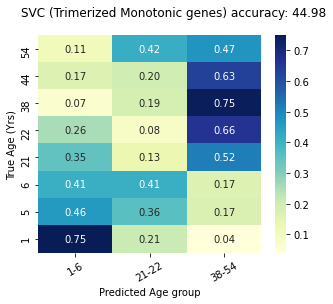

In [52]:
%%time
labels = vlm.ca['age'] # age labels
age = np.unique(labels)
print("Unique ages {}".format(age))

# feature and labels
X, y = nonp2, cat_labels

print(X.shape, y.shape, np.unique(y))

ypred = np.zeros(y.shape, dtype=int)
cm = pd.DataFrame(0, index=age, columns=np.asarray([0,1,2]))
print("cm", cm.shape)
m = SVC(kernel='sigmoid',C=10, degree=3, gamma='scale') # Accuracy: 44.98, recall: [54.00843882 11.62790698 64.45783133]

for a in age:
  samples = labels==a

  X_train, y_train = X[~samples], y[~samples]
  X_test, y_test = X[samples], y[samples]
  # print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)
  X_train, X_test = X_train.loc[:,genes], X_test.loc[:,genes]
  print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

  m.fit(X_train.values, y_train)
  pred = m.predict(X_test.values)
  ypred[samples] = pred
  
  # update confusion matrix
  uni, count = np.unique(pred, return_counts=True)
  for yp,ycount in zip(uni,count):
    cm.loc[a,yp] = ycount/y_test.shape[0] 

cm = cm.sort_index(axis=0, ascending=False)

# compute accuracy
acc = round((accuracy_score(y_true=y, y_pred=ypred))*100, 2)
print("Overall Accuracy:", acc)
recall = round((accuracy_score(y_true=y, y_pred=ypred))*100, 2)
print("Recall: ", recall)

# plot confusion matrix heatmap

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(cm, annot=True, fmt=".2f", cmap='YlGnBu')
plt.xlabel('Predicted Age group')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=["1-6", "21-22", "38-54"], rotation=30)
plt.ylabel('True Age (Yrs)')
fig.suptitle(f'SVC (Trimerized Monotonic genes) accuracy: {acc}')
plt.savefig(path['save']+'Vel_cm_age_tissue.pdf', bbox_inches='tight', dpi=600)

## Celltype wise prediction

In [16]:
%%time
age = np.unique(labels)
celltype_labels = vlm.ca['inferred_cell_type']
celltype = np.asarray(['acinar','alpha','beta','ductal'])
print("Unique age {}".format(age))

for ctype in celltype:
  print("="*30, "CELL TYPE {}".format(ctype), "="*30)
  csamples = celltype_labels == ctype
  X, y = nonp2[csamples], cat_labels[csamples]
  print("X", X.shape, "y", y.shape)

  ypred = np.zeros(y.shape, dtype=int)
  print("ypred", ypred.shape)
  cm = pd.DataFrame(0, index=age, columns=np.asarray([0,1,2]))

  # create classifier object
  m = SVC(kernel='sigmoid',C=10, degree=3, gamma='scale')

  for a in np.unique(age_labels[csamples]):
    # print("-"*30, "AGE {}".format(a), "-"*30)

    samples = age_labels[csamples]==a
    print("Age", a, samples.sum(), samples.shape)
    X_train, y_train = X[~samples], y[~samples]
    X_test, y_test = X[samples], y[samples]
    X_train, X_test = X_train.loc[:,genes], X_test.loc[:,genes]
    print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)
    # print("train test split done")

    m.fit(X_train.values, y_train)
    pred = m.predict(X_test.values)
    # print("prediction done")

    ypred[samples] = pred
    
    # update confusion matrix
    uni, count = np.unique(pred, return_counts=True)
    print(uni, count)
    for yp,ycount in zip(uni,count):
      cm.loc[a,yp] = ycount/y_test.shape[0] 

  cm = cm.sort_index(axis=0, ascending=False)
  # compute accuracy
  from sklearn.metrics import accuracy_score
  acc = round(accuracy_score(cat_labels[csamples], ypred)*100, 2)
  print("ACCURACY:", acc)

Unique age [ 1  5  6 21 22 38 44 54]
============================== CELL TYPE acinar ==============================
X (402, 16569) y (402,)
ypred (402,)
Age 1 54 (402,)
(54, 211) (54,) (348, 211) (348,)
[0 1 2] [47  1  6]
Age 5 103 (402,)
(103, 211) (103,) (299, 211) (299,)
[0 1 2] [25 18 60]
Age 6 35 (402,)
(35, 211) (35,) (367, 211) (367,)
[0 1 2] [32  2  1]
Age 21 74 (402,)
(74, 211) (74,) (328, 211) (328,)
[0 1 2] [41 11 22]
Age 22 10 (402,)
(10, 211) (10,) (392, 211) (392,)
[0 2] [7 3]
Age 38 75 (402,)
(75, 211) (75,) (327, 211) (327,)
[0 1 2] [ 1  3 71]
Age 44 18 (402,)
(18, 211) (18,) (384, 211) (384,)
[0 1 2] [10  5  3]
Age 54 33 (402,)
(33, 211) (33,) (369, 211) (369,)
[0 1 2] [18 14  1]
ACCURACY: 47.26
============================== CELL TYPE alpha ==============================
X (977, 16569) y (977,)
ypred (977,)
Age 1 38 (977,)
(38, 211) (38,) (939, 211) (939,)
[0 1 2] [16  6 16]
Age 5 59 (977,)
(59, 211) (59,) (918, 211) (918,)
[0 1 2] [34  3 22]
Age 6 71 (977,)
(71, 211)

## Accuracy Comparison between HDS and Transcriptional Noise

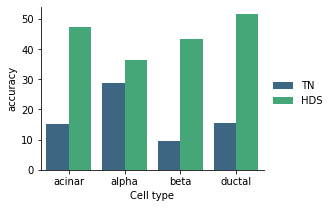

In [ ]:
df = pd.DataFrame(columns=['accuracy', 'method', 'Cell type'])

newrow = {'method' : 'TN',
          'accuracy' : 15.17,
          'Cell type' : 'acinar'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 47.26,
          'Cell type' : 'acinar'
          }
df = df.append(newrow, ignore_index=True)

# alpha
newrow = {'method' : 'TN',
          'accuracy' : 28.66,
          'Cell type' : 'alpha'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 36.44,
          'Cell type' : 'alpha'
          }
df = df.append(newrow, ignore_index=True)

# beta
newrow = {'method' : 'TN',
          'accuracy' : 9.5,
          'Cell type' : 'beta'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 43.32,
          'Cell type' : 'beta'
          }
df = df.append(newrow, ignore_index=True)

# ductal
newrow = {'method' : 'TN',
          'accuracy' : 15.57,
          'Cell type' : 'ductal'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 51.45,
          'Cell type' : 'ductal'
          }
df = df.append(newrow, ignore_index=True)
df

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
sns.barplot(y='accuracy', x='Cell type', data=df, hue='method', palette='viridis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6), frameon=False)

plt.savefig(path['save']+f'accuracy_comparison_TN_HDS_celltypes.pdf', bbox_inches='tight', dpi=600)
